In [1]:
import os
import threading
import numpy as np
from PIL import Image
from keras.utils.np_utils import to_categorical

base_path = '/atlas/home/zwpeng/datadreams/data/'


def get_picture(path):
    path0 = os.path.join(base_path, path)
    picture = []
    for _,_,filenames in os.walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(os.path.join(path0, file_prefix, ".tiff")):
                picture.append(filename)
            else: 
                os.path.exists(os.path.join(path0, file_prefix, ".jpg"))
                picture.append(filename)
    return picture

Using TensorFlow backend.


In [2]:
class ThreadsafeIter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    def g(*args, **kw):
        return ThreadsafeIter(f(*args, **kw))

    return g

In [64]:
@threadsafe_generator
def generator(train_set=True, batch_size=16, widths=128, heights=128):
    if train_set:
        cancer_set_path = 'train/cancer_subset/'
        non_cancer_set_path = 'train/non_cancer_subset/'
    else :
        cancer_set_path = 'validation/cancer_subset/'
        non_cancer_set_path = 'validation/non_cancer_subset/'

    mask_path = 'mask_new/'
    while True:
        images = []
        masks = []
        for i in range(batch_size):
            if (i % 2):  # 取到圈出的部分(含cancer)
                random_pic = np.random.choice(get_picture(cancer_set_path))
#                 print(random_pic)
                random_x = np.random.randint(0, 2048 - widths)
                random_y = np.random.randint(0, 2048 - heights)
                slide = Image.open(os.path.join(base_path, mask_path, os.path.splitext(random_pic)[0]+'.png.jpg'))
                slide1 = slide.crop((random_x, random_y, random_x + widths, random_y + heights))
                slide_gray = np.array(slide1.convert("L"))
                _,x = np.nonzero(slide_gray)
                while len(x) < 5000:
                    random_x = np.random.randint(0, 2048 - widths)
                    random_y = np.random.randint(0, 2048 - heights)
                    slide = Image.open(os.path.join(base_path, mask_path, os.path.splitext(random_pic)[0]+'.png.jpg'))
                    slide1 = slide.crop((random_x, random_y, random_x + widths, random_y + heights))
                    slide_gray = np.array(slide1.convert("L"))
                    _,x = np.nonzero(slide_gray)
                img = Image.open(os.path.join(base_path, cancer_set_path, random_pic))
                img2 = img.crop((random_x, random_y, random_x + widths, random_y + heights))
                img3 = np.array(img2.convert("RGB")) / 255.
                images.append(img3)
#                 masks.append(0)
                masks.append((slide_gray == 255).astype(int))
            else:  # 从non_cancer_set中取non_cancer
                random_pic = np.random.choice(get_picture(non_cancer_set_path))
                random_x = np.random.randint(0, 2048 - widths)
                random_y = np.random.randint(0, 2048 - heights)
                slide = Image.open(os.path.join(base_path, non_cancer_set_path, random_pic))
                slide1 = slide.crop((random_x, random_y, random_x + widths, random_y + heights))
                img = np.array(slide1.convert("RGB")) / 255.
                images.append(img)
#                 masks.append(1)
                masks.append(np.zeros((widths, heights)).astype(int))
        X = np.array(images)
        y = np.array(masks)
#         y = to_categorical(y, num_classes=2)
        y = to_categorical(y, num_classes=2).reshape(y.shape[0], widths, heights,2)
        yield X, y


In [ ]:
exam_X, exam_y = next(generator(widths=256, heights=256))
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,8,figsize=(20,5))
ax = axes.flatten()
for i,v in enumerate(exam_X):
    _ = ax[i].imshow(exam_X[i])
    _ = ax[i].set_title(exam_y[i])

fig,axes = plt.subplots(2,8,figsize=(20,5))
ax = axes.flatten()
for i,v in enumerate(exam_y):
    _ = ax[i].imshow(exam_y[i].argmax(axis=2),cmap='gray')

In [1]:
import os
import threading
import numpy as np
from PIL import Image
from mxnet import ndarray as nd
from mxnet import image as mx_image
from keras.utils.np_utils import to_categorical

base_path = '/atlas/home/zwpeng/datadreams/data/'


def get_picture(path):
    path0 = os.path.join(base_path, path)
    picture = []
    for _,_,filenames in os.walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(os.path.join(path0, file_prefix, ".tiff")):
                picture.append(filename)
            else:
                os.path.exists(os.path.join(path0, file_prefix, ".jpg"))
                picture.append(filename)
    return picture


class ThreadsafeIter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    def g(*args, **kw):
        return ThreadsafeIter(f(*args, **kw))

    return g


@threadsafe_generator
def generator(train_set=True, batch_size=16, widths=128, heights=128):
    if train_set:
        cancer_set_path = 'train/cancer_subset/'
        non_cancer_set_path = 'train/non_cancer_subset/'
    else :
        cancer_set_path = 'validation/cancer_subset/'
        non_cancer_set_path = 'validation/non_cancer_subset/'

    mask_path = 'mask_new/'
    while True:
        images = []
        masks = []
        for i in range(batch_size):
            if (i % 2):  # 取到圈出的部分(含cancer)
                random_pic = np.random.choice(get_picture(cancer_set_path))

                random_x = np.random.randint(0, 2048 - widths)
                random_y = np.random.randint(0, 2048 - heights)
                slide = Image.open(os.path.join(base_path, mask_path, os.path.splitext(random_pic)[0] + '.png.jpg'))
                slide1 = slide.crop((random_x, random_y, random_x + widths, random_y + heights))
                slide_gray = np.array(slide1.convert("L"))
                _,x = np.nonzero(slide_gray)
                while len(x) < 5000:
                    random_x = np.random.randint(0, 2048 - widths)
                    random_y = np.random.randint(0, 2048 - heights)
                    slide = Image.open(os.path.join(base_path, mask_path, os.path.splitext(random_pic)[0] + '.png.jpg'))
                    slide1 = slide.crop((random_x, random_y, random_x + widths, random_y + heights))
                    slide_gray = np.array(slide1.convert("L"))
                    _,x = np.nonzero(slide_gray)
                img = Image.open(os.path.join(base_path, cancer_set_path, random_pic))
                img2 = img.crop((random_x, random_y, random_x + widths, random_y + heights))
                # 数据增强部分
                img_r = img2.rotate(np.random.random(1)*360.)
                img = nd.array(img_r)
                aug = mx_image.HorizontalFlipAug(.5)
                img = aug(img.astype('float32'))
                aug = mx_image.HueJitterAug(.5)
                img = aug(img.astype('float32'))
                img = img.asnumpy()
#                img3 = np.array(img2.convert("RGB")) / 255.
                images.append(img/255.)
#                 masks.append(0)
                masks.append((slide_gray == 255).astype(int))
            else:  # 从non_cancer_set中取non_cancer
                random_pic = np.random.choice(get_picture(non_cancer_set_path))
                random_x = np.random.randint(0, 2048 - widths)
                random_y = np.random.randint(0, 2048 - heights)
                slide = Image.open(os.path.join(base_path, non_cancer_set_path, random_pic))
                slide1 = slide.crop((random_x, random_y, random_x + widths, random_y + heights))
                # 数据增强部分
                img_r = slide1.rotate(np.random.random(1)*360.)
                img = nd.array(img_r)
                aug = mx_image.HorizontalFlipAug(.5)
                img = aug(img.astype('float32'))
                aug = mx_image.HueJitterAug(.5)
                img = aug(img.astype('float32'))
                img = img.asnumpy()
                images.append(img/255.)
#                 masks.append(1)
                masks.append(np.zeros((widths, heights)).astype(int))
        X = np.array(images)
        y = np.array(masks)
#         y = to_categorical(y, num_classes=2)
        y = to_categorical(y, num_classes=2).reshape(y.shape[0], widths, heights, 2)
        yield X, y



Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  wrapper._legacy_support_signature = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py:212: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/labeled_tensor/python/ops/_typecheck.py:233: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(f)


In [2]:
exam_X, exam_y = next(generator(widths=256, heights=256))

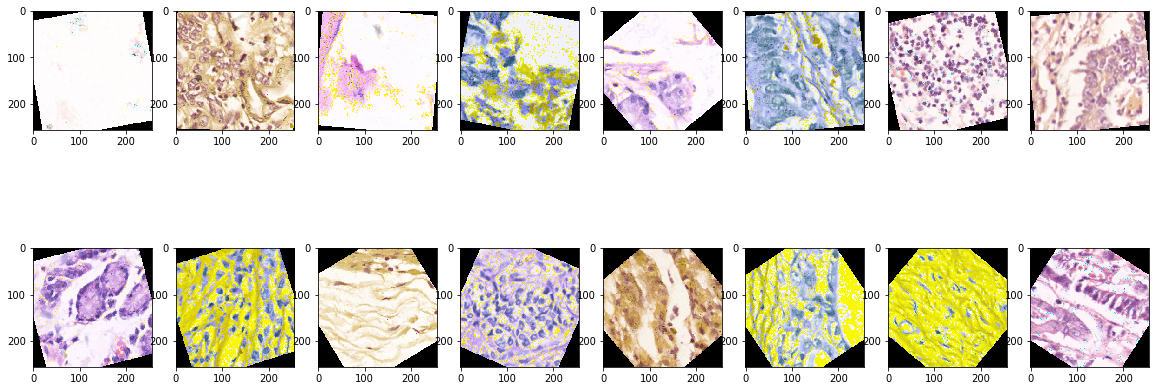

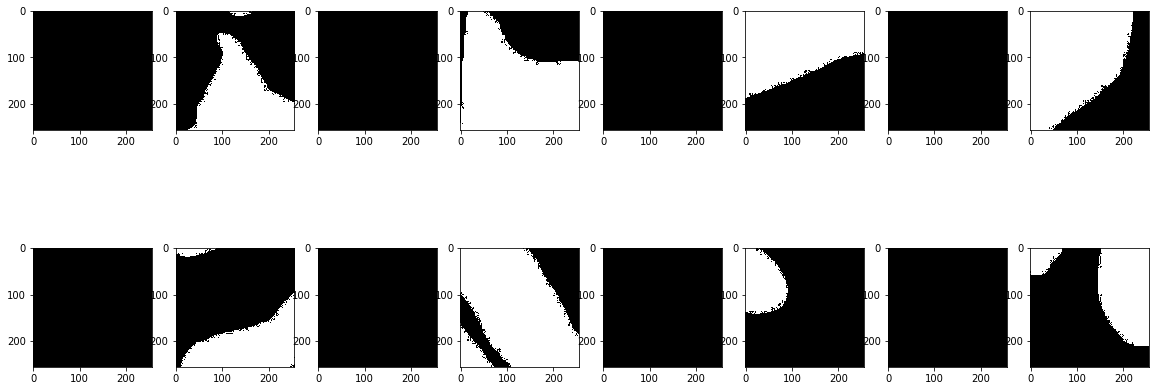

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,8,figsize=(20,8))
ax = axes.flatten()
for i,v in enumerate(exam_X):
    _ = ax[i].imshow(exam_X[i])
#     if exam_y[i][0]:
#         _ = ax[i].set_title('cancer')
#     else:
#         _ = ax[i].set_title('non cancer')

fig,axes = plt.subplots(2,8,figsize=(20,8))
ax = axes.flatten()
for i,v in enumerate(exam_y):
    _ = ax[i].imshow(exam_y[i].argmax(axis=2),cmap='gray')

In [4]:
exam_X, exam_y = next(generator(train_set=False,widths=256, heights=256))

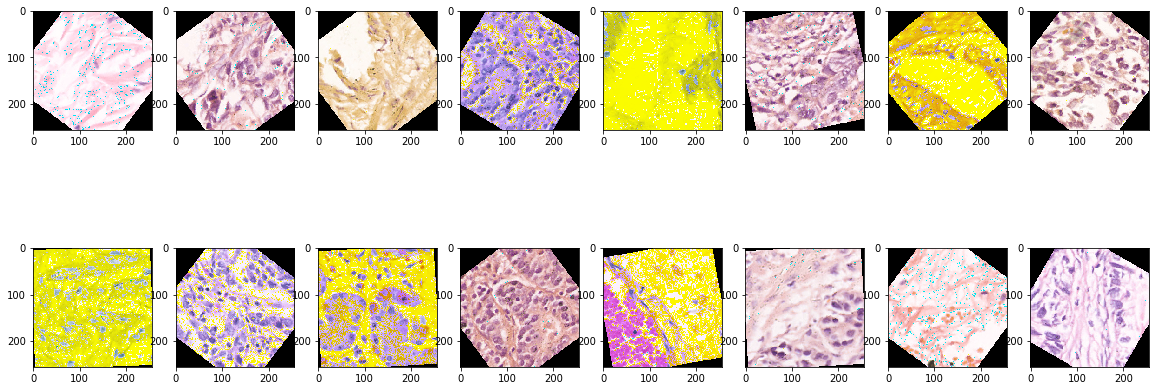

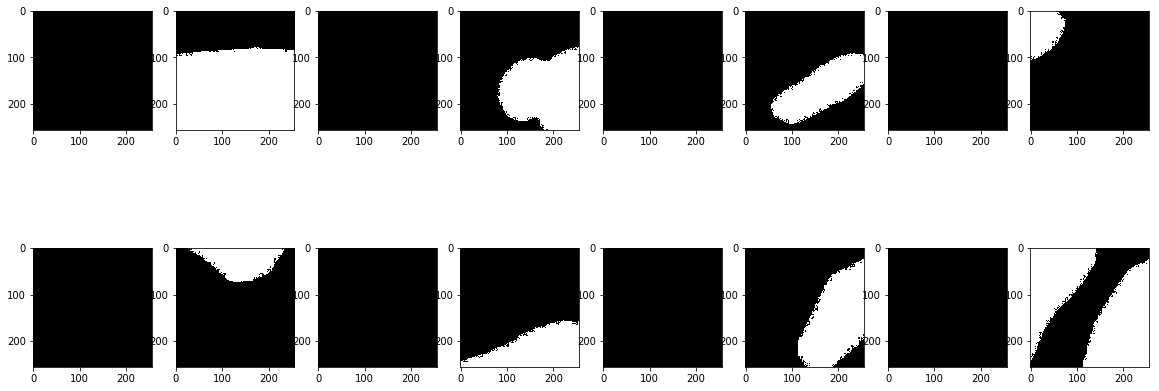

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,8,figsize=(20,8))
ax = axes.flatten()
for i,v in enumerate(exam_X):
    _ = ax[i].imshow(exam_X[i])
#     if exam_y[i][0]:
#         _ = ax[i].set_title('cancer')
#     else:
#         _ = ax[i].set_title('non cancer')

fig,axes = plt.subplots(2,8,figsize=(20,8))
ax = axes.flatten()
for i,v in enumerate(exam_y):
    _ = ax[i].imshow(exam_y[i].argmax(axis=2),cmap='gray')